In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:0000:01


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse
import requests
import gzip
import shutil
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
class DataProcessor:
    def __init__(self, clinical_data, rna_data, methylation_data, mutation_data):
        self.clinical_data = clinical_data
        self.rna_data = rna_data
        self.methylation_data = methylation_data
        self.mutation_data = mutation_data
        self.label_encoder = LabelEncoder()

    def preprocess_data(self):
        common_samples = list(set(self.clinical_data['sample_id']) &
                            set(self.rna_data.index) &
                            set(self.methylation_data.index) &
                            set(self.mutation_data.index))

        print(f"Common samples across all omics: {len(common_samples)}")

        self.clinical_data = self.clinical_data[self.clinical_data['sample_id'].isin(common_samples)]
        self.rna_data = self.rna_data.loc[common_samples]
        self.methylation_data = self.methylation_data.loc[common_samples]
        self.mutation_data = self.mutation_data.loc[common_samples]

        self.labels = self.label_encoder.fit_transform(self.clinical_data['pam50_subtype'])
        self.label_names = self.label_encoder.classes_

        print(f"Label distribution: {dict(zip(self.label_names, np.bincount(self.labels)))}")

        self.preprocess_rna_data()
        self.preprocess_methylation_data()
        self.preprocess_mutation_data()

        return self.create_integrated_data()

    def preprocess_rna_data(self):
        # Log transform and normalize
        self.rna_data = np.log2(self.rna_data.astype(float) + 1)

        # Feature selection - select top 500 most variable genes
        gene_vars = self.rna_data.var(axis=0)
        top_genes = gene_vars.nlargest(500).index
        self.rna_data = self.rna_data[top_genes]

        scaler = StandardScaler()
        self.rna_data = pd.DataFrame(
            scaler.fit_transform(self.rna_data),
            index=self.rna_data.index,
            columns=self.rna_data.columns
        )

    def preprocess_methylation_data(self):
        # Select top 200 most variable CpG sites
        cpg_vars = self.methylation_data.var(axis=0)
        top_cpgs = cpg_vars.nlargest(200).index
        self.methylation_data = self.methylation_data[top_cpgs]

        scaler = StandardScaler()
        self.methylation_data = pd.DataFrame(
            scaler.fit_transform(self.methylation_data),
            index=self.methylation_data.index,
            columns=self.methylation_data.columns
        )

    def preprocess_mutation_data(self):
        self.mutation_data = self.mutation_data.astype(float)
        self.mutation_data = self.mutation_data.fillna(0)

    def create_integrated_data(self):
        integrated_data = pd.concat([
            self.rna_data,
            self.methylation_data,
            self.mutation_data
        ], axis=1)

        self.feature_types = {}
        start_idx = 0

        end_idx = start_idx + len(self.rna_data.columns)
        self.feature_types['rna'] = list(range(start_idx, end_idx))
        start_idx = end_idx

        end_idx = start_idx + len(self.methylation_data.columns)
        self.feature_types['methylation'] = list(range(start_idx, end_idx))
        start_idx = end_idx

        end_idx = start_idx + len(self.mutation_data.columns)
        self.feature_types['mutation'] = list(range(start_idx, end_idx))

        print(f"Integrated data shape: {integrated_data.shape}")
        print(f"Feature types: RNA({len(self.feature_types['rna'])}), "
              f"Methylation({len(self.feature_types['methylation'])}), "
              f"Mutation({len(self.feature_types['mutation'])})")

        return integrated_data.values, self.labels

In [5]:
class GraphConstructor:
    def __init__(self, features, labels, feature_types):
        self.features = features
        self.labels = labels
        self.feature_types = feature_types

    def build_similarity_graph(self, k_neighbors=10):
        # Compute pairwise correlations between patients
        corr_matrix = np.corrcoef(self.features)

        # For each patient, connect to k most similar patients
        n_samples = len(self.features)
        edge_list = []

        for i in range(n_samples):
            # Get k most similar patients (excluding self)
            similarities = corr_matrix[i]
            similar_indices = np.argsort(similarities)[::-1][1:k_neighbors+1]

            for j in similar_indices:
                edge_list.append([i, j])

        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

        print(f"Graph constructed: {n_samples} nodes, {len(edge_list)} edges")
        return edge_index

    def build_feature_interaction_graph(self):
        # Compute feature correlations
        feature_corr = np.corrcoef(self.features.T)

        # Create edges for highly correlated features (|corr| > 0.5)
        threshold = 0.5
        n_features = self.features.shape[1]
        edge_list = []

        for i in range(n_features):
            for j in range(i+1, n_features):
                if abs(feature_corr[i, j]) > threshold:
                    edge_list.append([i, j])
                    edge_list.append([j, i])  # Undirected graph

        if len(edge_list) == 0:
            print("No strong correlations found, creating sparse random graph...")
            for i in range(n_features):
                # Connect each feature to 3 random other features
                connections = np.random.choice(
                    [j for j in range(n_features) if j != i],
                    size=min(3, n_features-1),
                    replace=False
                )
                for j in connections:
                    edge_list.append([i, j])

        feature_edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

        print(f"Feature graph: {n_features} nodes, {len(edge_list)} edges")
        return feature_edge_index

In [6]:
class MultiomicsGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, num_layers=3):
        super(MultiomicsGNN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # Feature embedding layers for different omics
        self.rna_embed = nn.Linear(500, hidden_dim // 3)  # RNA features
        self.methyl_embed = nn.Linear(200, hidden_dim // 3)  # Methylation features
        self.mutation_embed = nn.Linear(8, hidden_dim // 3)  # Mutation features

        # Calculate actual concatenated embedding dimension
        # This ensures the dimensions align properly
        embed_dim = (hidden_dim // 3) * 3  # This might not equal hidden_dim exactly

        # Graph convolution layers, use actual embedding dimension
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(embed_dim, hidden_dim))

        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        # Attention mechanism for omics integration
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # Split features by omics type
        rna_features = x[:, :500]  # First 500 features are RNA
        methyl_features = x[:, 500:700]  # Next 200 are methylation
        mutation_features = x[:, 700:]  # Last 8 are mutations

        # Embed each omics type
        rna_embed = self.rna_embed(rna_features)
        methyl_embed = self.methyl_embed(methyl_features)
        mutation_embed = self.mutation_embed(mutation_features)

        # Concatenate embeddings
        x = torch.cat([rna_embed, methyl_embed, mutation_embed], dim=1)

        # Apply graph convolutions
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)

        # Skip global pooling - we want node-level predictions
        # Each node (patient) gets its own prediction

        x = self.classifier(x)

        return x

In [7]:
class MTrainer:
    def __init__(self, features, labels, edge_index, n_classes, device='cuda'):
        self.features = torch.FloatTensor(features).to(device)
        self.labels = torch.LongTensor(labels).to(device)
        self.edge_index = edge_index.to(device)
        self.n_classes = n_classes
        self.device = device

        self.model = MultiomicsGNN(
            input_dim=features.shape[1],
            hidden_dim=128,
            output_dim=n_classes,
            dropout=0.3
        ).to(device)

        self.optimizer = Adam(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        self.criterion = nn.CrossEntropyLoss()

    def train_epoch(self):
        self.model.train()

        self.optimizer.zero_grad()
        out = self.model(self.features, self.edge_index)
        loss = self.criterion(out, self.labels)
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def evaluate(self, features, labels, edge_index):
        self.model.eval()
        with torch.no_grad():
            features = features.to(self.device)
            labels = labels.to(self.device)
            edge_index = edge_index.to(self.device)

            out = self.model(features, edge_index)
            pred = out.argmax(dim=1)
            acc = (pred == labels).float().mean()

        return acc.item(), pred.cpu().numpy()

    def train_and_evaluate(self, test_features, test_labels, test_edge_index, epochs=200):
        train_losses = []
        train_accuracies = []

        for epoch in range(epochs):
            loss = self.train_epoch()
            train_losses.append(loss)

            train_acc, _ = self.evaluate(self.features, self.labels, self.edge_index)
            train_accuracies.append(train_acc)

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}")

        test_acc, test_pred = self.evaluate(test_features, test_labels, test_edge_index)

        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

        return {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_accuracy': test_acc,
            'test_predictions': test_pred,
            'test_labels': test_labels.cpu().numpy()
        }

In [8]:
def plot_results(results, label_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(results['train_losses'])
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)

    axes[0, 1].plot(results['train_accuracies'])
    axes[0, 1].set_title('Training Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True)

    cm = confusion_matrix(results['test_labels'], results['test_predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')

    report = classification_report(results['test_labels'], results['test_predictions'],
                                 target_names=label_names, output_dict=True)

    metrics_df = pd.DataFrame(report).iloc[:-1, :-2].T  # Exclude support and averages
    sns.heatmap(metrics_df, annot=True, cmap='Greens', ax=axes[1, 1])
    axes[1, 1].set_title('Classification Metrics')

    plt.tight_layout()
    plt.savefig('gnn_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
def analyze_feature_importance(model, processor, device):
    model.eval()

    # Get model embeddings for each omics type
    sample_features = torch.randn(1, 708).to(device)  # Sample input

    with torch.no_grad():
        # Split features by omics type
        rna_features = sample_features[:, :500]
        methyl_features = sample_features[:, 500:700]
        mutation_features = sample_features[:, 700:]

        # Get embeddings
        rna_embed = model.rna_embed(rna_features)
        methyl_embed = model.methyl_embed(methyl_features)
        mutation_embed = model.mutation_embed(mutation_features)

        # Calculate embedding magnitudes as importance proxy
        rna_importance = torch.norm(rna_embed, dim=1).item()
        methyl_importance = torch.norm(methyl_embed, dim=1).item()
        mutation_importance = torch.norm(mutation_embed, dim=1).item()

    total_importance = rna_importance + methyl_importance + mutation_importance

    print("Omics Type Importance (based on embedding magnitudes):")
    print(f"RNA-seq: {rna_importance/total_importance:.3f}")
    print(f"Methylation: {methyl_importance/total_importance:.3f}")
    print(f"Mutation: {mutation_importance/total_importance:.3f}")

    omics_names = ['RNA-seq', 'Methylation', 'Mutation']
    importances = [rna_importance/total_importance,
                   methyl_importance/total_importance,
                   mutation_importance/total_importance]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(omics_names, importances, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Omics Type Importance for Cancer Subtype Prediction')
    plt.ylabel('Relative Importance')
    plt.ylim(0, max(importances) * 1.1)

    for bar, importance in zip(bars, importances):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{importance:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('omics_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
def save_results(model, results, processor, cv_scores):
    os.makedirs('results', exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dim': model.input_dim,
            'hidden_dim': model.hidden_dim,
            'output_dim': model.output_dim,
            'num_layers': model.num_layers
        },
        'label_encoder': processor.label_encoder,
        'feature_types': processor.feature_types
    }, 'results/multiomics_gnn_model.pth')

    results_summary = {
        'test_accuracy': results['test_accuracy'],
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'cv_scores': cv_scores,
        'label_names': processor.label_names.tolist(),
        'n_samples': len(processor.clinical_data),
        'n_features': {
            'rna': len(processor.feature_types['rna']),
            'methylation': len(processor.feature_types['methylation']),
            'mutation': len(processor.feature_types['mutation'])
        }
    }

    import json
    with open('results/results_summary.json', 'w') as f:
        json.dump(results_summary, f, indent=2)

    from sklearn.metrics import classification_report
    report = classification_report(
        results['test_labels'],
        results['test_predictions'],
        target_names=processor.label_names,
        output_dict=True
    )

    with open('results/classification_report.json', 'w') as f:
        json.dump(report, f, indent=2)

In [11]:
class ModelInterpreter:
    def __init__(self, model, processor, device):
        self.model = model
        self.processor = processor
        self.device = device

    def visualize_patient_embeddings(self, features, labels):
        #Visualize patient embeddings using t-SNE
        self.model.eval()
        with torch.no_grad():
            # Get embeddings from the model
            features_tensor = torch.FloatTensor(features).to(self.device)

            # Get intermediate embeddings (after graph convolutions)
            x = features_tensor

            rna_features = x[:, :500]
            methyl_features = x[:, 500:700]
            mutation_features = x[:, 700:]

            rna_embed = self.model.rna_embed(rna_features)
            methyl_embed = self.model.methyl_embed(methyl_features)
            mutation_embed = self.model.mutation_embed(mutation_features)

            embeddings = torch.cat([rna_embed, methyl_embed, mutation_embed], dim=1)
            embeddings = embeddings.cpu().numpy()

        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        colors = ['red', 'blue', 'green', 'orange', 'purple']

        for i, label_name in enumerate(self.processor.label_names):
            mask = labels == i
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=colors[i], label=label_name, alpha=0.7, s=50)

        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('Patient Embeddings by Cancer Subtype (PCA)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('results/patient_embeddings.png', dpi=300, bbox_inches='tight')
        plt.show()

        return embeddings_2d

    def analyze_subtype_characteristics(self):
        #Analyze characteristics of each cancer subtype
        subtype_stats = {}

        for subtype in self.processor.label_names:
            mask = self.processor.clinical_data['pam50_subtype'] == subtype
            subtype_data = self.processor.clinical_data[mask]

            stats = {
                'count': len(subtype_data),
                'mean_age': subtype_data['age'].mean(),
                'stage_distribution': subtype_data['tumor_stage'].value_counts().to_dict(),
                'er_positive_rate': (subtype_data['er_status'] == 'Positive').mean(),
                'pr_positive_rate': (subtype_data['pr_status'] == 'Positive').mean(),
                'her2_positive_rate': (subtype_data['her2_status'] == 'Positive').mean()
            }

            subtype_stats[subtype] = stats

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        ages_by_subtype = [self.processor.clinical_data[
            self.processor.clinical_data['pam50_subtype'] == subtype]['age'].values
            for subtype in self.processor.label_names]

        axes[0, 0].boxplot(ages_by_subtype, labels=self.processor.label_names)
        axes[0, 0].set_title('Age Distribution by Subtype')
        axes[0, 0].set_ylabel('Age')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Hormone receptor status
        receptor_data = []
        for subtype in self.processor.label_names:
            stats = subtype_stats[subtype]
            receptor_data.append([
                stats['er_positive_rate'],
                stats['pr_positive_rate'],
                stats['her2_positive_rate']
            ])

        receptor_df = pd.DataFrame(receptor_data,
                                 index=self.processor.label_names,
                                 columns=['ER+', 'PR+', 'HER2+'])

        sns.heatmap(receptor_df, annot=True, cmap='RdYlBu_r', ax=axes[0, 1])
        axes[0, 1].set_title('Hormone Receptor Status by Subtype')

        # Sample counts
        counts = [subtype_stats[subtype]['count'] for subtype in self.processor.label_names]
        axes[1, 0].bar(self.processor.label_names, counts, color='skyblue')
        axes[1, 0].set_title('Sample Count by Subtype')
        axes[1, 0].set_ylabel('Number of Samples')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Stage distribution
        stage_data = []
        stages = ['I', 'II', 'III', 'IV']

        for subtype in self.processor.label_names:
            stage_dist = subtype_stats[subtype]['stage_distribution']
            stage_counts = [stage_dist.get(stage, 0) for stage in stages]
            stage_data.append(stage_counts)

        stage_df = pd.DataFrame(stage_data,
                              index=self.processor.label_names,
                              columns=stages)

        stage_df.plot(kind='bar', stacked=True, ax=axes[1, 1])
        axes[1, 1].set_title('Tumor Stage Distribution by Subtype')
        axes[1, 1].set_ylabel('Number of Samples')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('results/subtype_characteristics.png', dpi=300, bbox_inches='tight')
        plt.show()

        return subtype_stats

In [12]:
def run_advanced_analysis(trainer, processor, features, labels, device):
    interpreter = ModelInterpreter(trainer.model, processor, device)
    embeddings_2d = interpreter.visualize_patient_embeddings(features, labels)

    subtype_stats = interpreter.analyze_subtype_characteristics()

    for subtype, stats in subtype_stats.items():
        print(f"\n{subtype}:")
        print(f"  Samples: {stats['count']}")
        print(f"  Mean age: {stats['mean_age']:.1f}")
        print(f"  ER+ rate: {stats['er_positive_rate']:.2%}")
        print(f"  PR+ rate: {stats['pr_positive_rate']:.2%}")
        print(f"  HER2+ rate: {stats['her2_positive_rate']:.2%}")

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
data_dir = "/kaggle/input/multiomics/"

clinical_data = pd.read_csv(os.path.join(data_dir, 'clinical_data.csv'))
rna_data = pd.read_csv(os.path.join(data_dir, 'rna_seq_data.csv'), index_col=0)
methylation_data = pd.read_csv(os.path.join(data_dir, 'methylation_data.csv'), index_col=0)
mutation_data = pd.read_csv(os.path.join(data_dir, 'mutation_data.csv'), index_col=0)

In [16]:
clinical_data

,sample_id,pam50_subtype,age,tumor_stage,er_status,pr_status,her2_status
0,TCGA-AA-0000,Luminal B,58,II,Positive,Positive,Positive
1,TCGA-AA-0001,Luminal A,21,II,Positive,Positive,Negative
2,TCGA-AA-0002,Luminal B,73,III,Positive,Negative,Negative
3,TCGA-AA-0003,Luminal B,82,I,Positive,Positive,Negative
4,TCGA-AA-0004,Luminal B,55,II,Negative,Positive,Negative
...,...,...,...,...,...,...,...
19995,TCGA-TR-1995,Luminal A,53,III,Positive,Positive,Negative
19996,TCGA-TR-1996,Basal-like,66,I,Positive,Positive,Negative
19997,TCGA-TR-1997,HER2-enriched,28,I,Negative,Positive,Negative
19998,TCGA-TR-1998,Luminal A,53,III,Positive,Positive,Negative


In [17]:
rna_data

,BRCA1,BRCA2,TP53,PIK3CA,ESR1,ERBB2,MYC,CCND1,Gene_0,Gene_1,...,Gene_1982,Gene_1983,Gene_1984,Gene_1985,Gene_1986,Gene_1987,Gene_1988,Gene_1989,Gene_1990,Gene_1991
TCGA-AA-0000,108.647469,118.825500,10.334425,8.865218,98.382834,12.318330,17.749157,207.506753,4.033808,38.713717,...,5.437720,31.407963,4.457307,21.217755,29.572630,21.224215,10.469354,23.055401,8.287163,21.784172
TCGA-AA-0001,3.238728,39.785082,6.792682,2.203072,38.457465,14.505159,91.977688,6.111923,25.244411,63.117848,...,7.104008,88.183404,35.607718,9.967091,4.910981,44.696208,14.889463,6.258546,8.236746,17.416078
TCGA-AA-0002,11.113372,21.271133,11.751868,76.815806,29.461953,12.704641,29.359497,168.124222,32.675927,28.211432,...,46.043769,71.714002,49.709601,39.856344,23.673661,13.291043,9.421347,5.528376,324.767704,96.009236
TCGA-AA-0003,4.206806,6.614787,22.311132,13.175296,54.249167,45.940585,79.087943,150.948292,27.175864,25.882229,...,42.513393,16.550567,105.890301,89.991748,8.488695,6.205953,17.581021,25.090336,14.147112,3.763697
TCGA-AA-0004,40.012380,50.742812,96.419864,15.800030,83.935619,14.083766,16.382307,13.051467,104.971892,24.496421,...,39.067586,18.173159,40.807920,10.630789,11.516193,7.733776,28.693372,26.115020,10.720656,14.970657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-TR-1995,31.907358,74.253759,27.871630,24.131099,112.027912,12.529226,16.454409,4.978347,19.074830,18.677932,...,23.351456,0.810471,9.875719,7.488653,13.418635,7.914513,8.218435,10.823776,10.285994,136.125775
TCGA-TR-1996,5.845227,7.549038,116.002828,62.235111,31.971704,11.422477,6.379094,57.537416,13.704059,53.601200,...,6.413600,5.775013,11.629961,37.182165,25.723243,101.257345,18.172393,8.550362,61.392659,40.303497
TCGA-TR-1997,13.110892,11.648458,13.033663,15.475793,43.078269,73.911812,12.954547,12.486387,80.687414,7.765436,...,8.082848,9.755526,1.762568,17.336776,4.708447,56.461836,50.620901,21.980392,23.645367,21.907136
TCGA-TR-1998,25.672595,25.676297,14.313022,12.991520,65.950636,7.411297,13.597065,27.781630,4.420859,14.419590,...,11.473009,10.144076,35.900004,71.199329,242.224586,72.907438,82.675467,11.658859,33.782776,27.431219


In [18]:
methylation_data

,cg00000000,cg00000001,cg00000002,cg00000003,cg00000004,cg00000005,cg00000006,cg00000007,cg00000008,cg00000009,...,cg00000990,cg00000991,cg00000992,cg00000993,cg00000994,cg00000995,cg00000996,cg00000997,cg00000998,cg00000999
TCGA-AA-0000,0.231663,0.566885,0.355122,0.532656,0.380601,0.534353,0.723071,0.637407,0.923534,0.456930,...,0.570507,0.401916,0.744628,0.648234,0.576144,0.351562,0.548268,0.799121,0.505259,0.898964
TCGA-AA-0001,0.790004,0.665655,0.529906,0.885687,0.508546,0.697740,0.575469,0.867361,0.459458,0.060391,...,0.772161,0.749115,0.676676,0.291160,0.323134,0.197472,0.340597,0.885733,0.513841,0.243475
TCGA-AA-0002,0.303086,0.429698,0.126418,0.622074,0.487296,0.296838,0.419047,0.845487,0.451361,0.592734,...,0.424338,0.571789,0.358982,0.798191,0.731342,0.903310,0.236779,0.275023,0.471278,0.641836
TCGA-AA-0003,0.879371,0.461926,0.623599,0.518951,0.198451,0.670108,0.703775,0.711075,0.515493,0.765140,...,0.098673,0.646548,0.262860,0.058330,0.203228,0.523746,0.808736,0.767367,0.142533,0.903881
TCGA-AA-0004,0.295574,0.280018,0.497586,0.900028,0.492325,0.530599,0.277849,0.289132,0.681183,0.580884,...,0.668171,0.710053,0.630588,0.208357,0.304521,0.731492,0.203862,0.376943,0.677004,0.324741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-TR-1995,0.565853,0.369511,0.732757,0.923327,0.898537,0.874549,0.937594,0.187770,0.665442,0.848349,...,0.240638,0.397717,0.302213,0.423643,0.462894,0.377124,0.767284,0.310617,0.708227,0.370141
TCGA-TR-1996,0.499108,0.649186,0.565768,0.247243,0.158262,0.333420,0.367795,0.300060,0.265870,0.310424,...,0.339633,0.331694,0.362231,0.699133,0.185997,0.247821,0.701286,0.135970,0.652080,0.752873
TCGA-TR-1997,0.227810,0.349119,0.367021,0.786757,0.668173,0.749566,0.602675,0.294854,0.478939,0.769321,...,0.417188,0.391979,0.609678,0.404489,0.614899,0.974268,0.711894,0.354811,0.684190,0.590013
TCGA-TR-1998,0.458488,0.859448,0.834101,0.859484,0.388651,0.437012,0.679638,0.136855,0.420048,0.819182,...,0.414319,0.493067,0.192329,0.250609,0.618663,0.791572,0.688460,0.480165,0.123274,0.559320


In [19]:
mutation_data

,TP53,PIK3CA,CDH1,GATA3,MAP3K1,NCOR1,AKT1,FOXA1
TCGA-AA-0000,0,1,0,0,1,0,0,0
TCGA-AA-0001,0,0,0,0,0,0,0,0
TCGA-AA-0002,0,0,0,0,0,0,0,0
TCGA-AA-0003,0,0,1,0,0,0,1,0
TCGA-AA-0004,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
TCGA-TR-1995,0,0,0,0,0,0,0,1
TCGA-TR-1996,1,1,1,0,0,0,0,1
TCGA-TR-1997,0,0,0,0,1,0,0,0
TCGA-TR-1998,0,0,0,0,0,0,0,0


In [20]:
processor = DataProcessor(clinical_data, rna_data, methylation_data, mutation_data)

In [21]:
features, labels = processor.preprocess_data()

Common samples across all omics: 20000
Label distribution: {'Basal-like': 3077, 'HER2-enriched': 3007, 'Luminal A': 7945, 'Luminal B': 4915, 'Normal-like': 1056}
Integrated data shape: (20000, 708)
Feature types: RNA(500), Methylation(200), Mutation(8)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )

In [23]:
X_train.shape[0]

16000

In [24]:
X_test.shape[0]

4000

In [25]:
graph_constructor_train = GraphConstructor(X_train, y_train, processor.feature_types)
train_edge_index = graph_constructor_train.build_similarity_graph(k_neighbors=8)

Graph constructed: 16000 nodes, 128000 edges


In [26]:
graph_constructor_test = GraphConstructor(X_test, y_test, processor.feature_types)
test_edge_index = graph_constructor_test.build_similarity_graph(k_neighbors=8)

Graph constructed: 4000 nodes, 32000 edges


In [27]:
trainer = MTrainer(
        features=X_train,
        labels=y_train,
        edge_index=train_edge_index,
        n_classes=len(processor.label_names),
        device=device
    )

In [28]:
test_features = torch.FloatTensor(X_test)
test_labels = torch.LongTensor(y_test)

In [29]:
test_features.shape

torch.Size([4000, 708])

In [30]:
results = trainer.train_and_evaluate(
        test_features, test_labels, test_edge_index, epochs=30000
)

Epoch 50/30000: Loss = 1.4397, Train Acc = 0.3973
Epoch 100/30000: Loss = 1.4002, Train Acc = 0.4006
Epoch 150/30000: Loss = 1.3084, Train Acc = 0.4418
Epoch 200/30000: Loss = 1.2496, Train Acc = 0.4883
Epoch 250/30000: Loss = 1.2036, Train Acc = 0.5251
Epoch 300/30000: Loss = 1.1616, Train Acc = 0.5249
Epoch 350/30000: Loss = 1.1258, Train Acc = 0.5746
Epoch 400/30000: Loss = 1.0960, Train Acc = 0.6043
Epoch 450/30000: Loss = 1.0603, Train Acc = 0.6273
Epoch 500/30000: Loss = 1.0303, Train Acc = 0.6364
Epoch 550/30000: Loss = 1.0239, Train Acc = 0.6726
Epoch 600/30000: Loss = 0.9818, Train Acc = 0.6903
Epoch 650/30000: Loss = 0.9643, Train Acc = 0.7073
Epoch 700/30000: Loss = 0.9372, Train Acc = 0.7202
Epoch 750/30000: Loss = 0.9236, Train Acc = 0.7342
Epoch 800/30000: Loss = 0.9066, Train Acc = 0.7429
Epoch 850/30000: Loss = 0.8953, Train Acc = 0.7548
Epoch 900/30000: Loss = 0.8758, Train Acc = 0.7619
Epoch 950/30000: Loss = 0.8704, Train Acc = 0.7756
Epoch 1000/30000: Loss = 0.8655,

In [31]:
results['test_accuracy']

0.31550002098083496

In [32]:
print(classification_report(results['test_labels'], results['test_predictions'],
                              target_names=processor.label_names))

               precision    recall  f1-score   support

   Basal-like       0.15      0.06      0.09       616
HER2-enriched       0.15      0.07      0.10       601
    Luminal A       0.39      0.62      0.48      1589
    Luminal B       0.23      0.20      0.21       983
  Normal-like       0.04      0.01      0.02       211

     accuracy                           0.32      4000
    macro avg       0.19      0.19      0.18      4000
 weighted avg       0.26      0.32      0.27      4000



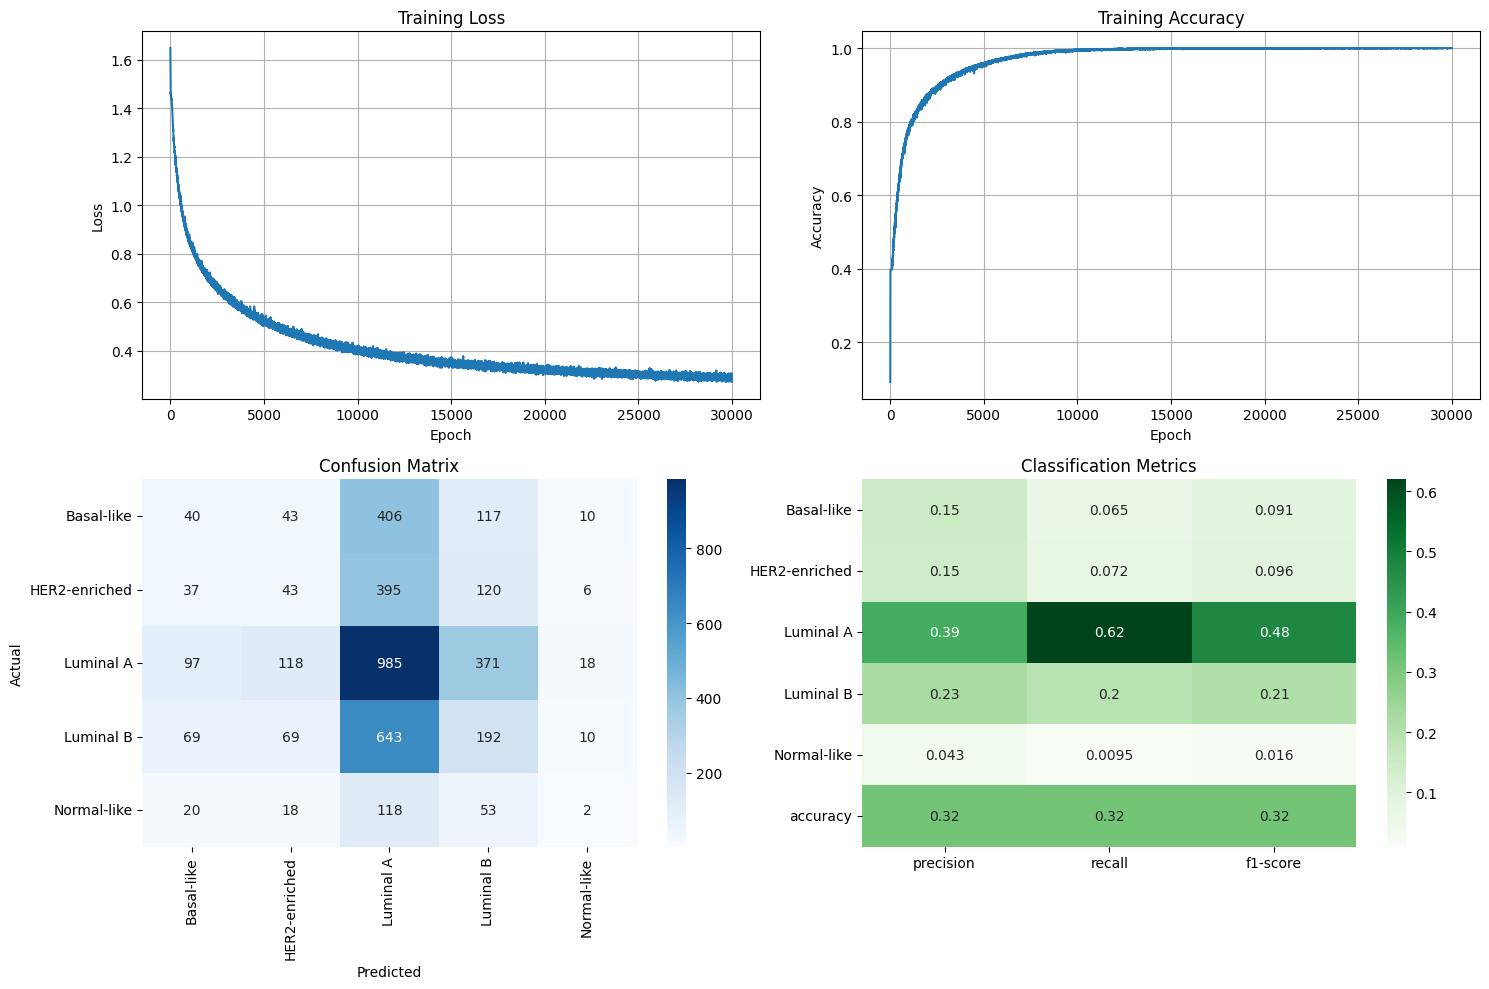

In [33]:
plot_results(results, processor.label_names)

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels)):
    print(f"Fold {fold + 1}/5")

    X_fold_train, X_fold_val = features[train_idx], features[val_idx]
    y_fold_train, y_fold_val = labels[train_idx], labels[val_idx]

    fold_graph_constructor = GraphConstructor(X_fold_train, y_fold_train, processor.feature_types)
    fold_train_edge_index = fold_graph_constructor.build_similarity_graph(k_neighbors=8)

    fold_val_graph_constructor = GraphConstructor(X_fold_val, y_fold_val, processor.feature_types)
    fold_val_edge_index = fold_val_graph_constructor.build_similarity_graph(k_neighbors=8)


    fold_trainer = MTrainer(
          features=X_fold_train,
          labels=y_fold_train,
          edge_index=fold_train_edge_index,
          n_classes=len(processor.label_names),
          device=device
      )
    fold_results = fold_trainer.train_and_evaluate(
      torch.FloatTensor(X_fold_val), torch.LongTensor(y_fold_val),
      fold_val_edge_index, epochs=10000
      )

    cv_scores.append(fold_results['test_accuracy'])
    print(f"Fold {fold + 1} Accuracy: {fold_results['test_accuracy']:.4f}")

Fold 1/5
Graph constructed: 16000 nodes, 128000 edges
Graph constructed: 4000 nodes, 32000 edges
Epoch 50/10000: Loss = 1.4367, Train Acc = 0.3973
Epoch 100/10000: Loss = 1.3932, Train Acc = 0.4046
Epoch 150/10000: Loss = 1.3129, Train Acc = 0.4249
Epoch 200/10000: Loss = 1.2519, Train Acc = 0.4597
Epoch 250/10000: Loss = 1.2038, Train Acc = 0.4987
Epoch 300/10000: Loss = 1.1618, Train Acc = 0.5278
Epoch 350/10000: Loss = 1.1302, Train Acc = 0.5524
Epoch 400/10000: Loss = 1.0970, Train Acc = 0.5946
Epoch 450/10000: Loss = 1.0693, Train Acc = 0.6172
Epoch 500/10000: Loss = 1.0446, Train Acc = 0.6468
Epoch 550/10000: Loss = 1.0205, Train Acc = 0.6648
Epoch 600/10000: Loss = 1.0039, Train Acc = 0.6838
Epoch 650/10000: Loss = 0.9742, Train Acc = 0.7001
Epoch 700/10000: Loss = 0.9576, Train Acc = 0.7120
Epoch 750/10000: Loss = 0.9336, Train Acc = 0.7279
Epoch 800/10000: Loss = 0.9249, Train Acc = 0.7374
Epoch 850/10000: Loss = 0.9115, Train Acc = 0.7459
Epoch 900/10000: Loss = 0.8918, Train

In [35]:
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")

Mean Accuracy: 0.3126 ± 0.0146
Individual fold scores: ['0.3140', '0.3060', '0.3283', '0.3263', '0.2882']


Omics Type Importance (based on embedding magnitudes):
RNA-seq: 0.421
Methylation: 0.401
Mutation: 0.178


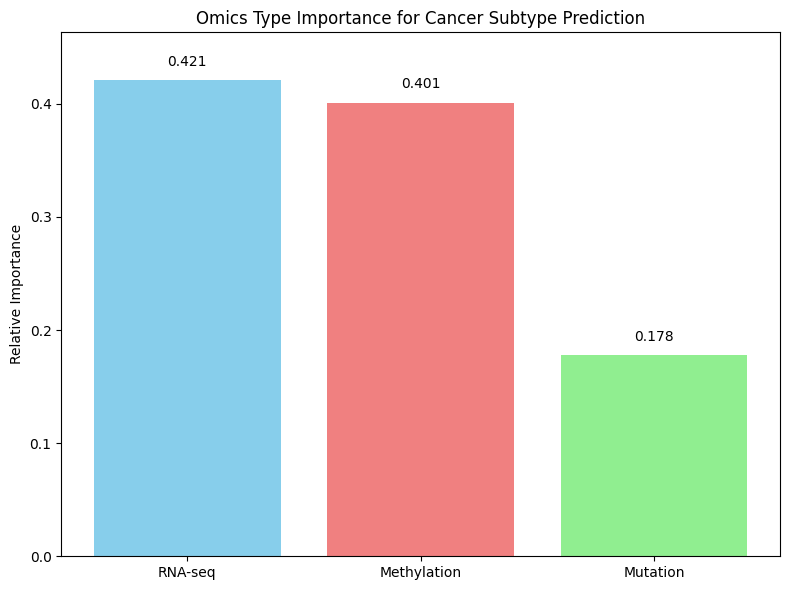

In [36]:
analyze_feature_importance(trainer.model, processor, device)

In [37]:
save_results(trainer.model, results, processor, cv_scores)

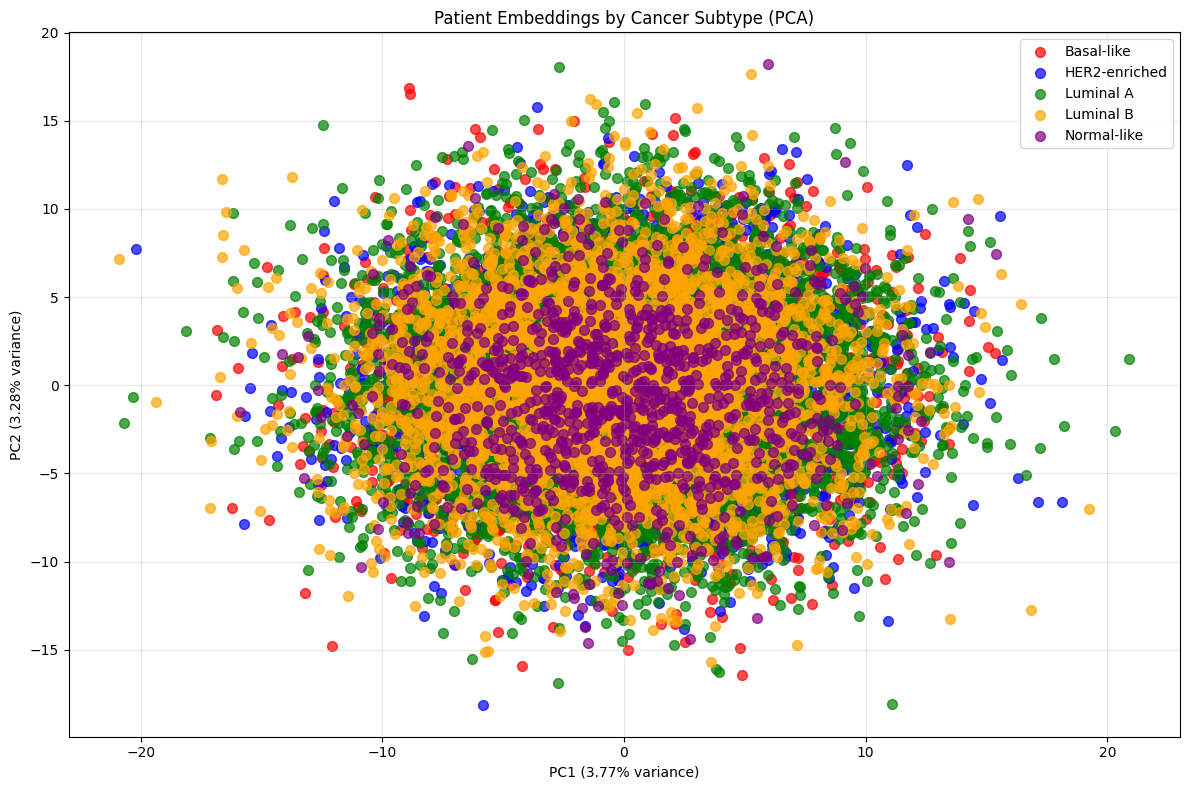

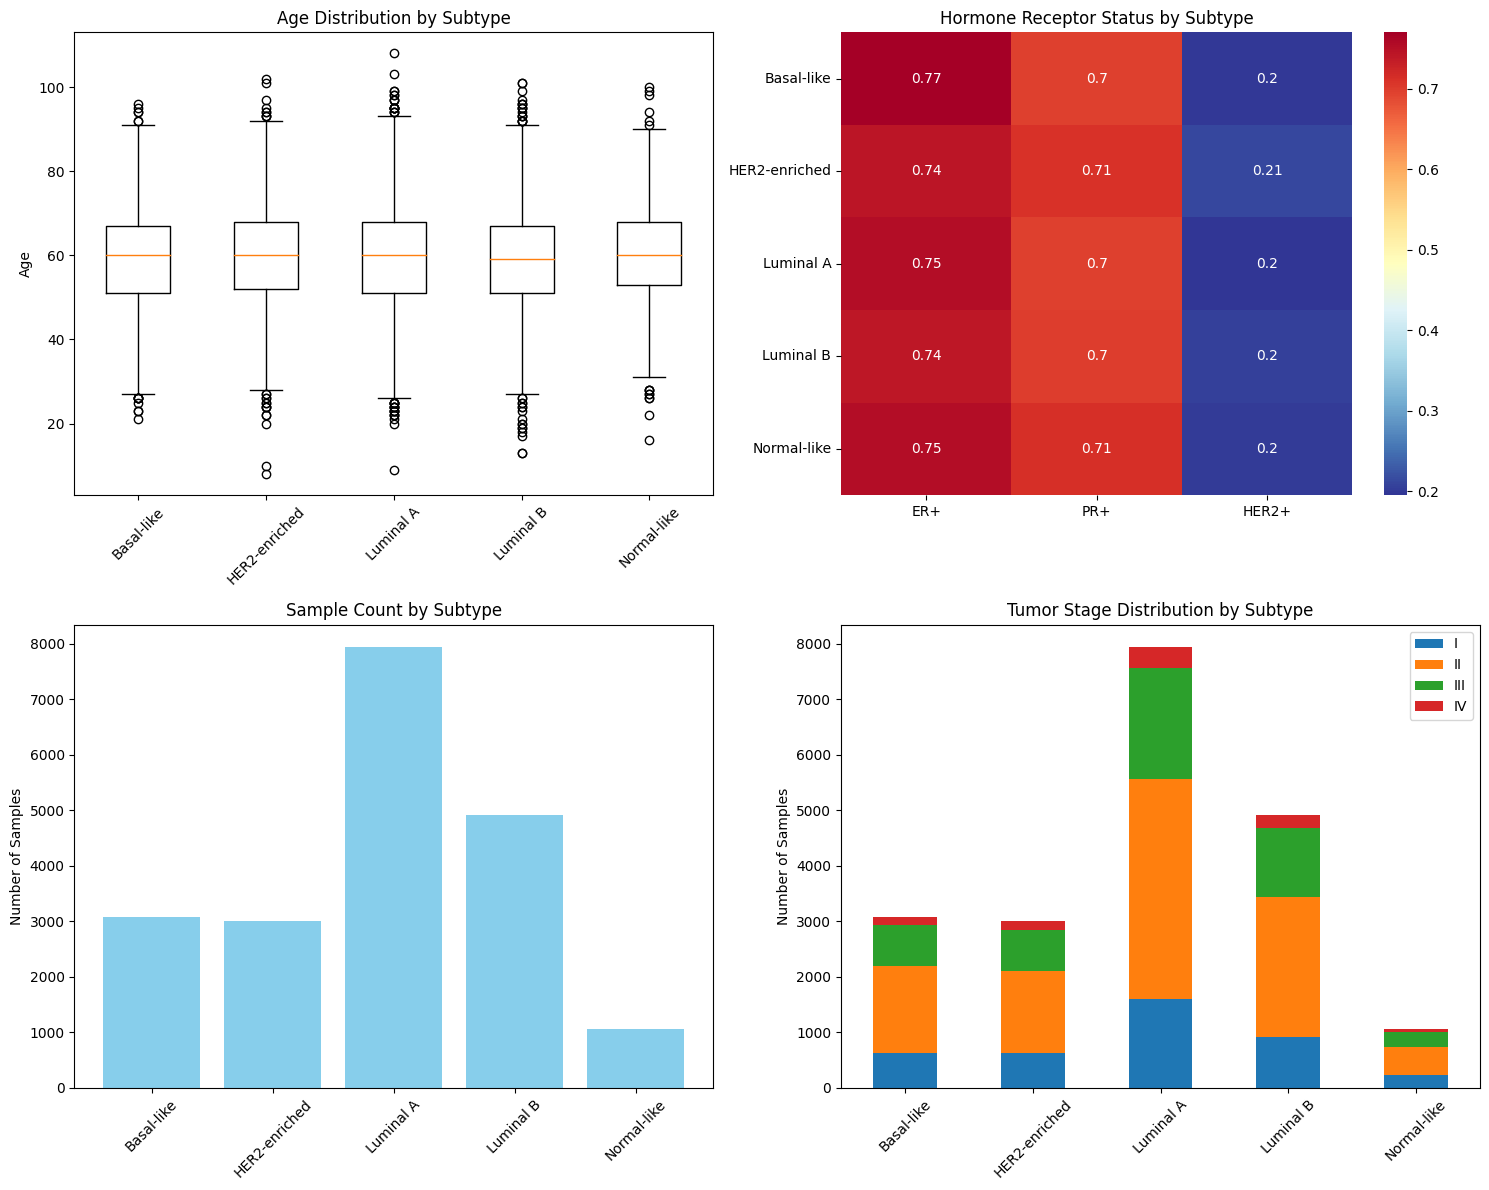


Basal-like:
  Samples: 3077
  Mean age: 59.3
  ER+ rate: 77.02%
  PR+ rate: 69.74%
  HER2+ rate: 19.99%

HER2-enriched:
  Samples: 3007
  Mean age: 59.6
  ER+ rate: 74.36%
  PR+ rate: 71.10%
  HER2+ rate: 21.18%

Luminal A:
  Samples: 7945
  Mean age: 59.7
  ER+ rate: 75.36%
  PR+ rate: 69.70%
  HER2+ rate: 19.55%

Luminal B:
  Samples: 4915
  Mean age: 59.3
  ER+ rate: 74.16%
  PR+ rate: 69.95%
  HER2+ rate: 20.47%

Normal-like:
  Samples: 1056
  Mean age: 60.0
  ER+ rate: 75.38%
  PR+ rate: 71.31%
  HER2+ rate: 20.17%


In [38]:
run_advanced_analysis(trainer, processor, features, labels, device)